### Import Libraries, Import Data

In [65]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
from bs4 import BeautifulSoup, Comment
import requests
from operator import itemgetter
import os
from IPython.display import clear_output
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import AdaBoostClassifier
import warnings
import operator
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

In [2]:
# fitting on 3rd degree interactions
df_full = pd.read_csv("full_deg3.csv")
df_pitcher = pd.read_csv("pitcher_data.csv")

del df_full["Unnamed: 0"]
del df_pitcher["Unnamed: 0"]

In [59]:
df_full = df_full.sort_values(['game_id', 'play_number'], ascending=[1, 1])
df_pitcher = df_pitcher.sort_values(['game_id', 'play_number'], ascending=[1, 1])

### Helper Functions

In [55]:
# helper function to print confusion matrix
def conf_mat(y_real, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_real, y_pred).ravel()
    
    print("\nCONFUSION MATIX:")
    print("{0:6} {1:6} {2:6}".format("", "pred +", "pred -"))
    print("{0:6} {1:6} {2:6}".format("true +", tp, fn))
    print("{0:6} {1:6} {2:6}".format("true -", fp, tn))
    
    if tp == 0 and fp == 0:
        tpr = 0
    else:
        tpr = tp / (tp + fp)
        
    if tn == 0 and fn == 0:
        tnr = 0
    else:
        tnr = tn / (tn + fn)
    
    print("\nTRUE POSITIVE:", tpr)
    print("TRUE NEGATIVE:", tnr)
    
def classification_accuracy(y_true, y_pred):
    total_missed = 0
    for i in range(len(y_true)):
        if y_true[i] != y_pred[i]:
            total_missed += 1
    return 1 - (total_missed/len(y_true))

def predicted_prob(pred_prob, win_or_not):
    win_prob = []
    
    print("writing probabilities")
    
    # record predicted win probabilities at each step
    for i in range(len(pred_prob)):
        # if team wins
        if win_or_not[i] == 1:
            win_prob.append(pred_prob[i][1])
        else:
            win_prob.append(pred_prob[i][0])
            
        if i % 200000 == 0:
            print("iter", i)
            
    prob_change = []
    
    play_counts = np.array(df_full["play_number"])
    
    print("writing probability changes")
    
    # calculate change in win probability between each event
    for i in range(len(win_prob)):
        if play_counts[i] == 1:
            prob_change.append(win_prob[i] - 0.5)
        else:
            prob_change.append(win_prob[i] - win_prob[i - 1])
            
        if i % 200000 == 0:
            print("iter", i)
            
    return [win_prob, prob_change]

def split_data(df):
    msk = np.random.rand(len(df)) < 0.5

    data_train = df[msk]
    data_test = df[~msk]
    
    return (data_train, data_test)

def sample(df, k):
    n = df.shape[0] # No. of training points
    
    # Choose random indices of size 'k'
    subset_ind = np.random.choice(np.arange(n - k), 1)[0]
    
    # Get predictors and reponses with the indices
    subset = df.iloc[subset_ind:subset_ind + k].copy()
    
    return subset

### Split into Test and Train, Get Predictors

In [49]:
response = "win"
not_to_include = ["wWPA", "wWE", "play_number", "game_id"]
predictors = [x for x in list(df_full) if x != response and x not in not_to_include]

In [19]:
train, test = split_data(df_full)

### Logistic Regression

In [81]:
# function to fit logistic regression model, report confusion matrix and save predicted 
# probabilities at each point in game
def fit_log_model(df_full, df, dfTest, df_pitcher, response, predictors):

    # get test/train sets
    y_train = df[response]
    y_test = dfTest[response]

    x_train = df[predictors]
    x_test = dfTest[predictors]
    
    log_model = LogisticRegressionCV()
    
    print("fitting")

    log_model.fit(x_train, y_train)

    print("MODEL SCORE:", log_model.score(x_test, y_test))

    y_pred_test = log_model.predict(x_test)
    
    conf_mat(y_test, y_pred_test)
    
    print("\npredicting probabilities")
    
    x_full = df_full[predictors]
    y_full = df_full[response]
    
    # predict probabilities of each event for every game in dataset
    pred_prob = log_model.predict_proba(x_full)
    
    [win_prob, prob_change] = predicted_prob(pred_prob, np.array(y_full))
    
    # put the predicted probabilities in the pitcher dataframe
    df_pitcher["logistic_prob"] = win_prob
    df_pitcher["logistic_prob_change"] = prob_change
    
    print("done fitting logistic regression model")
    
fit_log_model(df_full, train, test, df_pitcher, response, predictors)

fitting
MODEL SCORE: 0.704860582051

CONFUSION MATIX:
       pred + pred -
true + 217197  76264
true -  94192 189891

TRUE POSITIVE: 0.697510188221
TRUE NEGATIVE: 0.713460201762

predicting probabilities
writing probabilities
iter 0
iter 200000
iter 400000
iter 600000
iter 800000
iter 1000000
writing probability changes
iter 0
iter 200000
iter 400000
iter 600000
iter 800000
iter 1000000
done fitting logistic regression model


### Random Forest

In [71]:
subset = sample(df_full, 5000)

train_sub, test_sub = split_data(subset)

In [61]:
# fit our actual model
# use 256 trees because time is a thing, but more trees is better so we compromise!
def fit_rf_model(df_full, df_train, df_test, df_pitcher, preds, response, n_estimators, max_depth):
    rf_model = RandomForestClassifier(n_estimators = n_estimators, max_depth = max_depth)
    
    print("fitting model")
    
    rf_model.fit(df_train[preds], df_train[response])
    
    print("predicting")
    
    y_hat = rf_model.predict(df_test[preds])
    print("Overall accuracy: {}".format(classification_accuracy(df_test['win'].values, y_hat)))
    conf_mat(df_test[response].values, y_hat)
    
    print("predicting probabilities")
    
    pred_prob = np.array(rf_model.predict_proba(df_full[preds]))
    
    print(pred_prob.shape)
    
    [win_prob, prob_change] = predicted_prob(pred_prob, np.array(df_full[response]))
    
    # put the predicted probabilities in the pitcher dataframe
    df_pitcher["rf_prob"] = win_prob
    df_pitcher["rf_prob_change"] = prob_change
    
# fit_rf_model(df_full, train, test, df_pitcher, predictors, response, 256, 48)
fit_rf_model(df_full, train, test, df_pitcher, predictors, response, 256, 48)

fitting model
predicting
Overall accuracy: 0.7178189021096228

CONFUSION MATIX:
       pred + pred -
true + 216927  76534
true -  86438 197645

TRUE POSITIVE: 0.715069305952
TRUE NEGATIVE: 0.720861189223
predicting probabilities
(1156906, 2)
writing probabilities
iter 0
iter 200000
iter 400000
iter 600000
iter 800000
iter 1000000
writing probability changes
iter 0
iter 200000
iter 400000
iter 600000
iter 800000
iter 1000000


## Adaboost

In [77]:
def ada_fit(df, train, test, size, depth, predictors, response):
    ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=depth), 
                                 n_estimators=size, learning_rate=0.05)
    ada.fit(train[predictors], train[response])
    y_hat = ada.predict(test[predictors])
    print("Overall accuracy: {}".format(classification_accuracy(test[response].values, y_hat)))
    conf_mat(test[response].values, y_hat)
    
    pred_prob = np.array(ada.predict_proba(df[predictors]))
    
    [win_prob, prob_change] = predicted_prob(pred_prob, np.array(df[response]))
    
    # put the predicted probabilities in the pitcher dataframe
    df_pitcher["ada_prob"] = win_prob
    df_pitcher["ada_prob_change"] = prob_change
    
best_size_ada = 128
best_depth = 5

ada_fit(df_full, train, test, best_size_ada, best_depth, predictors, response)

Overall accuracy: 0.7210134639092433

CONFUSION MATIX:
       pred + pred -
true + 215212  78249
true -  82878 201205

TRUE POSITIVE: 0.72196987487
TRUE NEGATIVE: 0.719993272596
writing probabilities
iter 0
iter 200000
iter 400000
iter 600000
iter 800000
iter 1000000
writing probability changes
iter 0
iter 200000
iter 400000
iter 600000
iter 800000
iter 1000000


### Game Visualization Code

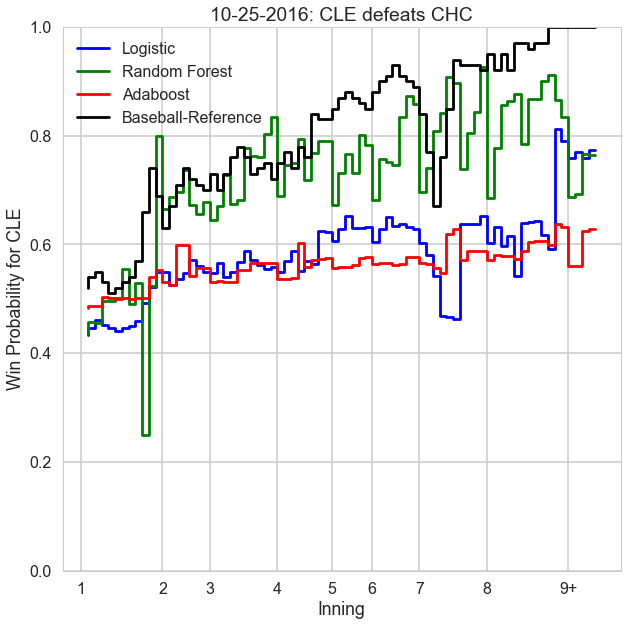

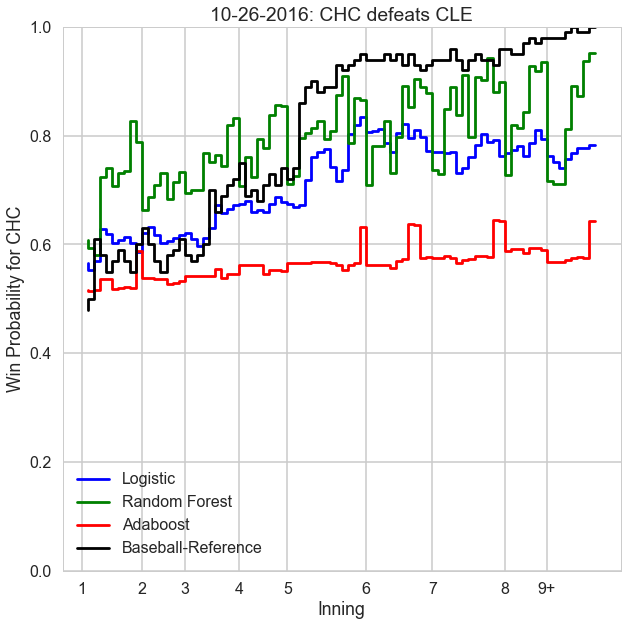

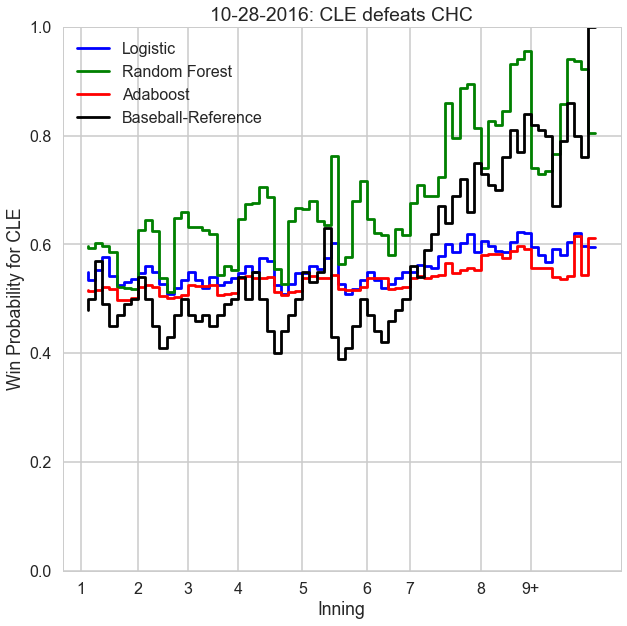

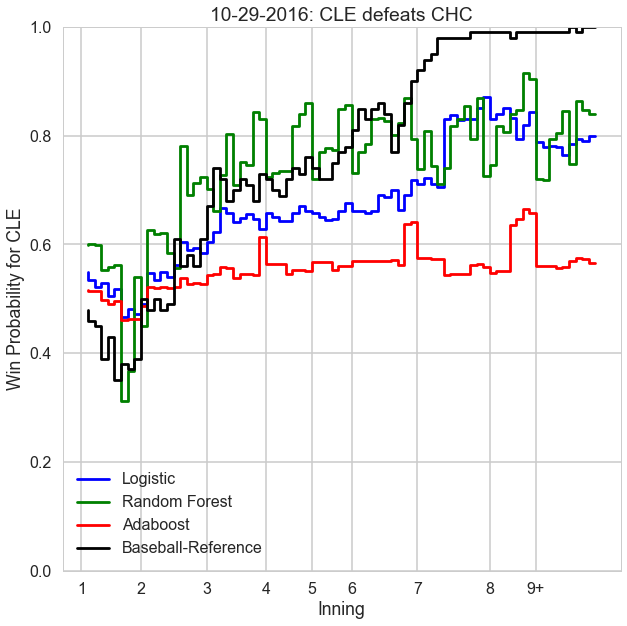

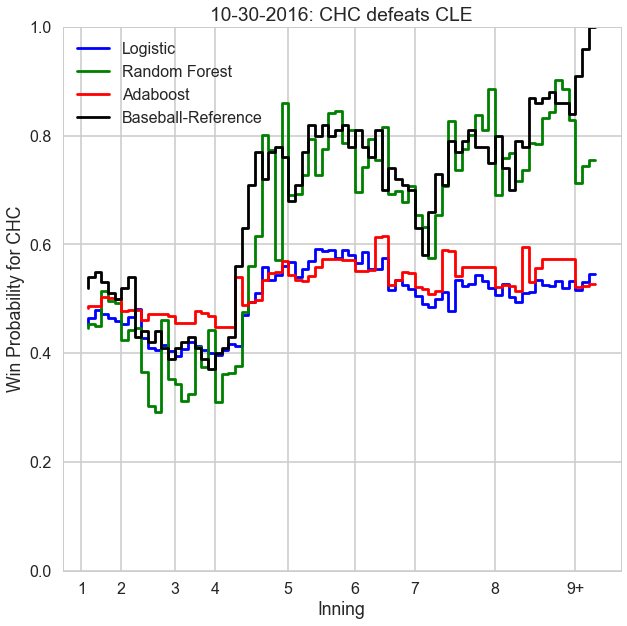

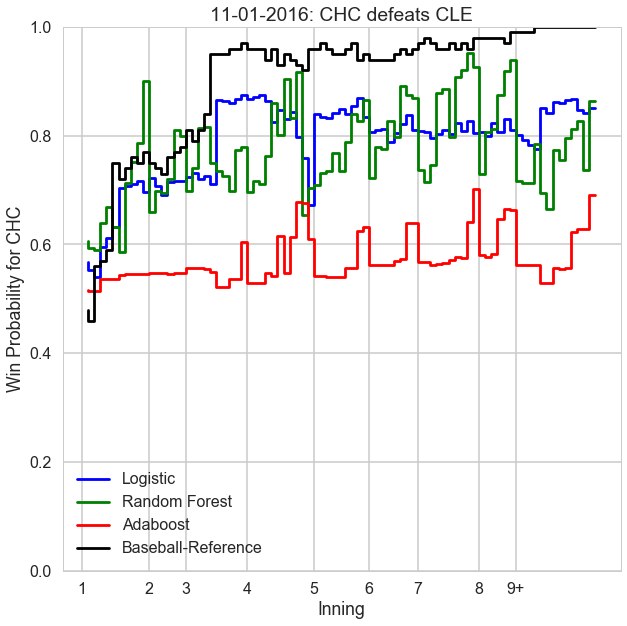

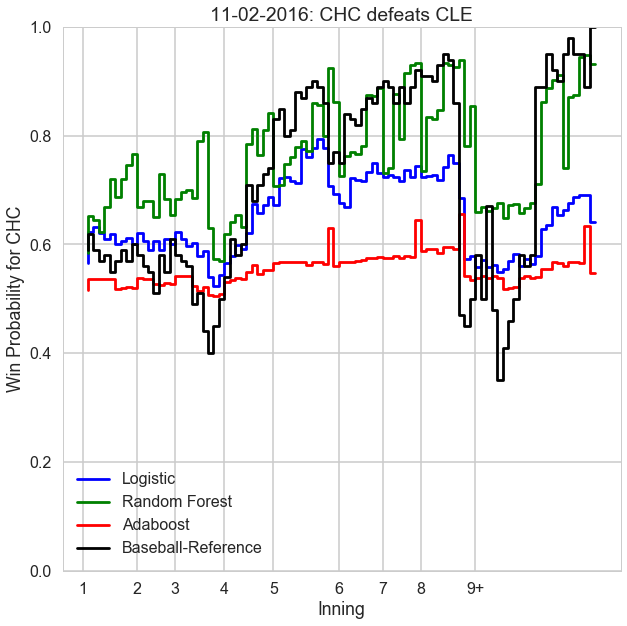

In [107]:
def make_plot(game_id, filename):
    game = df_pitcher.loc[df_pitcher["game_id"] == game_id]
    winner = (game[game["win"] == 1].iloc[0])["@Bat"]
    loser = (game[game["win"] == 0].iloc[0])["@Bat"]
    innings = sorted(set(game["Inn"]))
    ticks = []
    for inning in innings:
        cur = game[game["Inn"] == inning].iloc[0]["play_number"] - 1
        ticks.append(cur)
    plt.figure(figsize=(10,10))
    plt.step(game["play_number"], game["logistic_prob"], color="blue", label="Logistic")
    plt.step(game["play_number"], game["rf_prob"], color="green", label="Random Forest")
    plt.step(game["play_number"], game["ada_prob"], color="red", label="Adaboost")
    plt.step(game["play_number"], np.array(game["wWE"])/100, color="black", label="Baseball-Reference")
    plt.xticks(ticks, innings)
    plt.xlabel("Inning")
    plt.ylabel("Win Probability for " + winner)
    plt.ylim([0,1])
    plt.legend()
    year, month, day = game_id[3:7], game_id[7:9], game_id[9:11]
    plt.title("{}-{}-{}: {} defeats {}".format(month, day, year, winner, loser))
    plt.savefig("game{}.png".format(filename), dpi=300)

game_ids = ["CLE201610250", "CLE201610260", "CHN201610280", "CHN201610290", "CHN201610300",
      "CLE201611010", "CLE201611020"]
for i,game_id in enumerate(game_ids):
    make_plot(game_id, i+1)

### Player Visualization Code

In [110]:
def calculate_total_win_prob_added(df, prob_var):
    pitchers = set(df["Pitcher"])

    pitcher_WPA = {}
    pitcher_count = {}
    print("number of pitchers:", len(pitchers))

    for i,pitcher in enumerate(pitchers):
        pitcher_WPA.setdefault(pitcher, 0)
        pitcher_count.setdefault(pitcher, 0)

        pitcher_rows = df.loc[df['Pitcher'] == pitcher].sort_values(['game_id', 'play_number'], ascending=[1, 1])
        pitcher_count[pitcher] += pitcher_rows.shape[0]

        for index, row in pitcher_rows.iterrows():
            if int(row["win"]) == 1:
                pitcher_WPA[pitcher] += float(row[prob_var])
            else:
                pitcher_WPA[pitcher] -= float(row[prob_var])

        if i % 100 == 0 and i != 0:
            clear_output()
            print("number of pitchers:", len(pitchers))
            print("iter", i)

    pitcher_all = []
    for pitcher,wpa in pitcher_WPA.items():
        pitcher_all.append([pitcher, pitcher_count[pitcher], wpa])

    return pitcher_all

clear_output()

pitcher_scores = calculate_total_win_prob_added(df_pitcher, "rf_prob_change")

number of pitchers: 1521
iter 1500


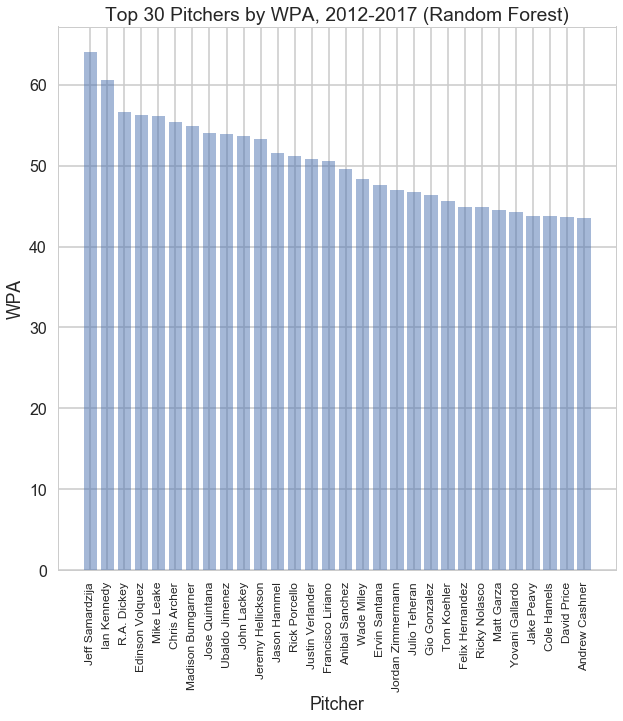

In [117]:
sorted_pitchers = sorted(pitcher_scores, key=operator.itemgetter(2), reverse = True)

x_pos_pitch = np.arange(len(sorted_pitchers[:30]))
plt.figure(figsize=(10,10))
plt.bar(x_pos_pitch, [x[2] for x in sorted_pitchers[:30]], align='center', alpha=0.5)
plt.xticks(x_pos_pitch, [x[0] for x in sorted_pitchers[:30]], rotation='vertical', fontsize=12)
plt.xlabel('Pitcher')
plt.title('Top 30 Pitchers by WPA, 2012-2017 (Random Forest)')
plt.ylabel('WPA')
plt.savefig("top30pitchers.png",dpi=300)
plt.show()

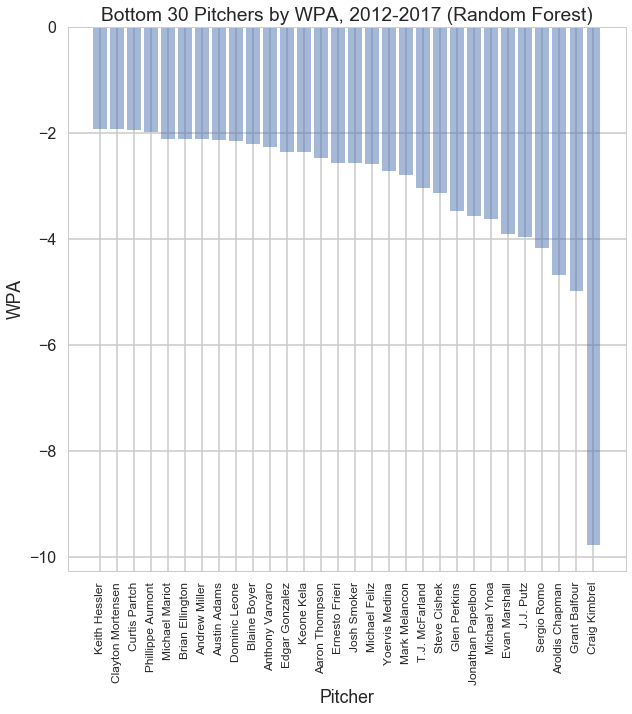

In [118]:
x_pos_pitch = np.arange(len(sorted_pitchers[-30:]))
plt.figure(figsize=(10,10))
plt.bar(x_pos_pitch, [x[2] for x in sorted_pitchers[-30:]], align='center', alpha=0.5)
plt.xticks(x_pos_pitch, [x[0] for x in sorted_pitchers[-30:]], rotation='vertical', fontsize=12)
plt.xlabel('Pitcher')
plt.title('Bottom 30 Pitchers by WPA, 2012-2017 (Random Forest)')
plt.ylabel('WPA')
plt.savefig("worst30pitchers.png",dpi=300)
plt.show()

### Team Visualization Code

In [92]:
df_ninth_inning = df_pitcher.loc[df_pitcher["Inn"] == "9+"]

In [102]:
def calculate_team_eight_ninth_prob(df, prob_var):
    teams = set(df["@Bat"])
    
    team_WPA = {}
    print("number of teams:", len(teams))
    
    for i,team in enumerate(teams):
        team_WPA.setdefault(team, 0)
        
        team_rows = df.loc[df['@Bat'] == team].sort_values(['game_id', 'play_number'], ascending=[1, 1])
        
        for index, row in team_rows.iterrows():
            if int(row["win"]) == 1:
                team_WPA[team] += float(row["rf_prob_change"])
            else:
                team_WPA[team] -= float(row["rf_prob_change"])
            
        if i % 5 == 0 and i != 0:
            clear_output()
            print("number of teams:", len(teams))
            print("iter", i)
            
    team_all = []
    for team,wpa in team_WPA.items():
        team_all.append([team, wpa])
                
    return team_all

clear_output()

team_data = calculate_team_eight_ninth_prob(df_ninth_inning, "rf_prob_change")

number of teams: 30
iter 25


In [105]:
sorted_teams = sorted(team_data, key=operator.itemgetter(1), reverse = True)

['COL', 'NYY', 'OAK', 'CHW', 'KCR', 'SDP', 'TEX', 'TOR', 'LAD', 'CHC', 'HOU', 'BAL', 'BOS', 'CIN', 'DET', 'LAA', 'MIL', 'ATL', 'MIN', 'SFG', 'CLE', 'PIT', 'WSN', 'PHI', 'TBR', 'STL', 'MIA', 'SEA', 'ARI', 'NYM']


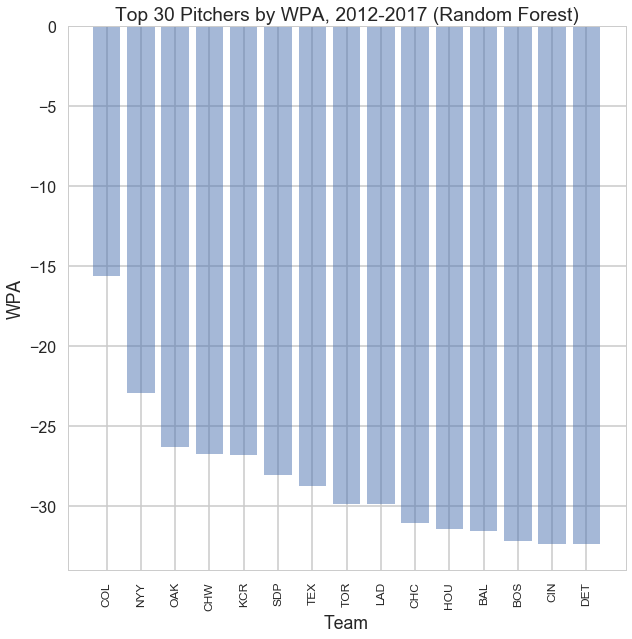

In [125]:
x_pos_team = np.arange(len(sorted_pitchers[:15]))
plt.figure(figsize=(10,10))
plt.bar(x_pos_team, [x[1] for x in sorted_teams[:15]], align='center', alpha=0.5)
plt.xticks(x_pos_team, [x[0] for x in sorted_teams[:15]], rotation='vertical', fontsize=12)
plt.xlabel('Team')
plt.title('Top 30 Pitchers by WPA, 2012-2017 (Random Forest)')
plt.ylabel('WPA')
plt.savefig("top15teams.png",dpi=300)
plt.show()